In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install thop

Device: cuda

Loading MHEALTH dataset...
Before removing label 0: 1215745 samples
After removing label 0: 343195 samples
Dataset Split:
  Train: 5185 samples
  Val:   1685 samples
  Test:  1697 samples
  Shape: (samples, channels=23, time_steps=200)

Model parameters: 805,400
Trainable parameters: 805,400

Starting training for 100 epochs...
Epoch | Train Loss | Train Acc | Val Loss | Val Acc |    Best
----------------------------------------------------------------------
    1 |     1.3412 |    23.76% |   1.1933 |  23.32% |   0.00%
      New best validation accuracy: 23.32% (model saved)
    2 |     0.9973 |    34.77% |   1.0086 |  30.45% |  23.32%
      New best validation accuracy: 30.45% (model saved)
    3 |     0.6283 |    61.12% |   0.8546 |  48.37% |  30.45%
      New best validation accuracy: 48.37% (model saved)
    4 |     0.2915 |    85.55% |   0.5699 |  57.09% |  48.37%
      New best validation accuracy: 57.09% (model saved)
    5 |     0.1668 |    97.07% |   0.4992 |  73

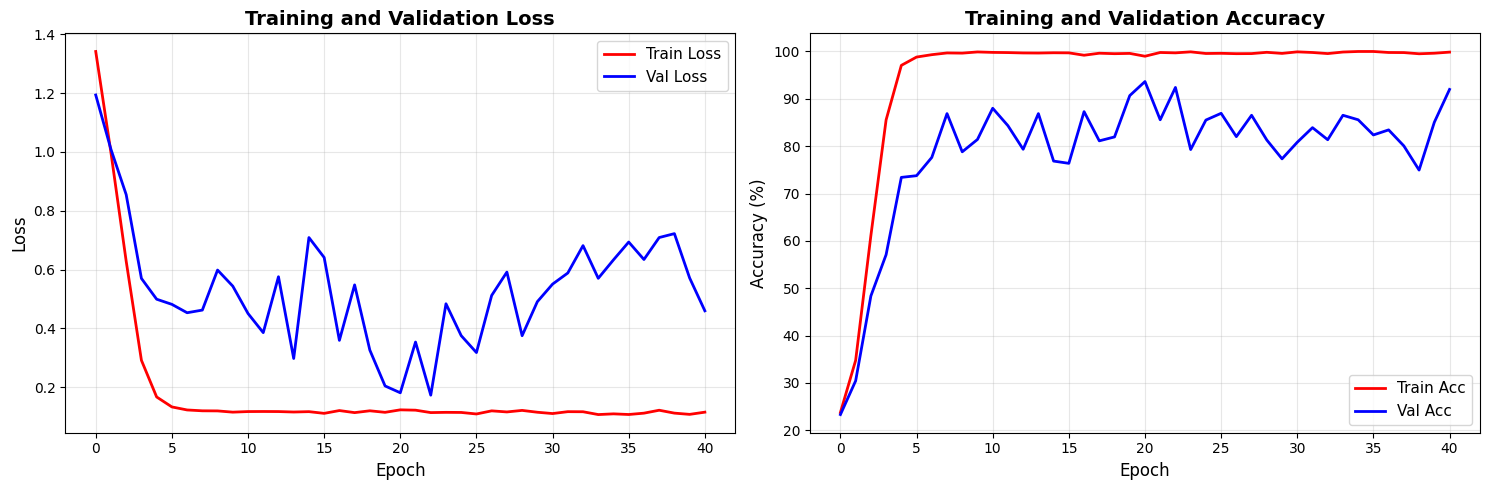

Training history saved to training_history.png

Loading best model for evaluation...

FINAL TEST SET EVALUATION (Unseen Data)
→ Reparameterizing ELK blocks for inference speed-up...

Classification Report:
                           precision    recall  f1-score   support

           Standing still     0.9868    0.9934    0.9901       151
     Sitting and relaxing     0.9870    0.9870    0.9870       154
               Lying down     0.9615    0.9804    0.9709       153
                  Walking     0.9933    0.9675    0.9803       154
          Climbing stairs     0.9625    1.0000    0.9809       154
      Waist bends forward     0.8333    0.9774    0.8997       133
Frontal elevation of arms     1.0000    0.9858    0.9929       141
Knees bending (crouching)     1.0000    0.8014    0.8897       146
                  Cycling     0.9871    0.9935    0.9903       154
                  Jogging     0.9870    0.9935    0.9902       153
                  Running     0.9871    0.9935    0.9903

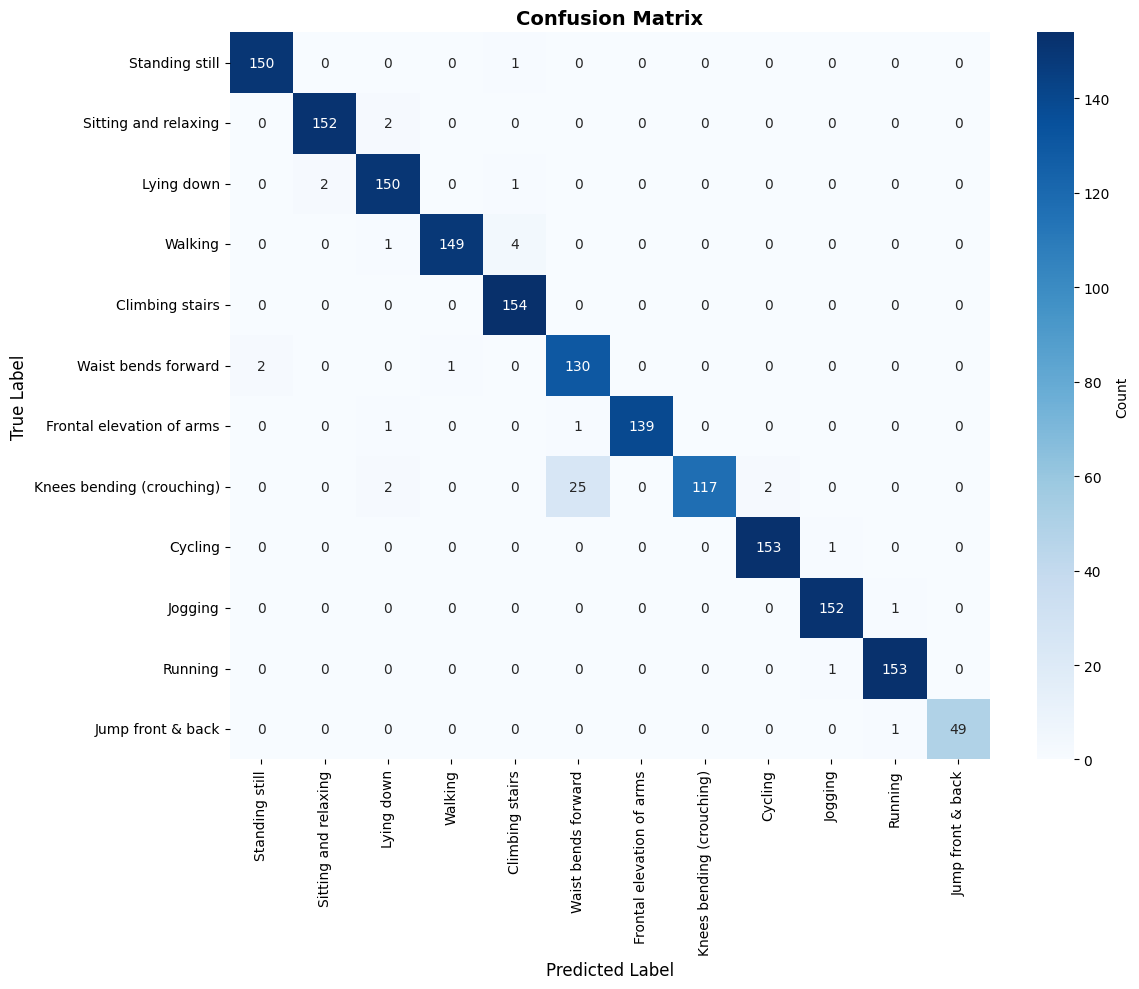

Confusion matrix saved to confusion_matrix.png

FINAL PERFORMANCE SUMMARY
Metric                    Value          
----------------------------------------------------------------------
Test Accuracy (%)         97.11          
F1 Score (Macro)          0.9710         
Recall (Macro)            0.9711         
Precision (Macro)         0.9738         
Parameters (M)            0.6385         
FLOPs (M)                 13433.7495     
Inference Time (ms)       0.28           
Best Val Accuracy (%)     93.65          
Best Epoch                21             


In [3]:
# ============================================================
# MHEALTH + ELK Backbone + Sequential Cross-Attention + Temporal Prototype Attention
# Modified: ModernTCN → ELKBlock with Structural Reparameterization
# With comprehensive visualization and metrics
# ============================================================
import os, math, time, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from thop import profile

# ---------------------------
# 0) MHEALTH Dataset Loader
# ---------------------------
class MhealthDataset(Dataset):
    def __init__(self, data, labels):
        if data.ndim != 3:
            raise ValueError(f"Data needs to be 3D (samples, channels, sequence), but got {data.shape}")
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def create_dataset(X, y, time_steps=200, step=40):
    xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X[i:i + time_steps]
        labels = y[i:i + time_steps]
        values, counts = np.unique(labels, return_counts=True)
        mode_label = values[np.argmax(counts)]
        xs.append(v)
        ys.append(mode_label)
    return np.array(xs), np.array(ys)

def load_mhealth_raw(dataset_path, TIME_STEPS=200, STEP=40):
    col_names = [
        'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
        'ecg1', 'ecg2',
        'acc_left_ankle_x', 'acc_left_ankle_y', 'acc_left_ankle_z',
        'gyro_left_ankle_x', 'gyro_left_ankle_y', 'gyro_left_ankle_z',
        'magnet_left_ankle_x', 'magnet_left_ankle_y', 'magnet_left_ankle_z',
        'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z',
        'gyro_right_arm_x', 'gyro_right_arm_y', 'gyro_right_arm_z',
        'magnet_right_arm_x', 'magnet_right_arm_y', 'magnet_right_arm_z',
        'label', 'subject'
    ]

    dfs = []
    for i in range(1, 11):
        path = os.path.join(dataset_path, f"mHealth_subject{i}.log")
        df_i = pd.read_csv(path, sep='\t', header=None)
        df_i['subject'] = i
        dfs.append(df_i)

    df = pd.concat(dfs, ignore_index=True)
    df = df.dropna(how='any', axis=0)
    df.columns = col_names

    # Remove label 0 (null/no activity)
    print(f"Before removing label 0: {len(df)} samples")
    df = df[df.label != 0]
    print(f"After removing label 0: {len(df)} samples")

    # Adjust labels to start from 0 (1->0, 2->1, ..., 12->11)
    df['label'] = df['label'] - 1

    # Split by subject
    train = df[~df['subject'].isin([7, 8, 9, 10])]
    val = df[df['subject'].isin([7, 8])]
    test = df[df['subject'].isin([9, 10])]

    X_train = train.drop(['label', 'subject'], axis=1).values
    y_train = train['label'].values

    X_val = val.drop(['label', 'subject'], axis=1).values
    y_val = val['label'].values

    X_test = test.drop(['label', 'subject'], axis=1).values
    y_test = test['label'].values

    # Standardization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Create sliding windows
    X_train, y_train = create_dataset(X_train, y_train, TIME_STEPS, STEP)
    X_val, y_val = create_dataset(X_val, y_val, TIME_STEPS, STEP)
    X_test, y_test = create_dataset(X_test, y_test, TIME_STEPS, STEP)

    # Transpose to (samples, channels, time_steps)
    X_train = X_train.transpose(0, 2, 1)
    X_val = X_val.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)

    return X_train, y_train, X_val, y_val, X_test, y_test

# ---------------------------
# 1) ELK Backbone
# ---------------------------
class ELKBlock(nn.Module):
    """
    Efficient Large Kernel Block with structural reparameterization.
    """
    def __init__(self, in_channels, out_channels, kernel_size=31, deploy=False):
        super().__init__()
        self.deploy = deploy
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # Calculate paddings
        padding_large1 = kernel_size // 2
        kernel_size_large2 = kernel_size - 2
        padding_large2 = kernel_size_large2 // 2
        kernel_size_small1 = 5
        padding_small1 = kernel_size_small1 // 2
        kernel_size_small2 = 3
        padding_small2 = kernel_size_small2 // 2

        if deploy:
            self.reparam_conv = nn.Conv1d(
                in_channels, in_channels, kernel_size,
                padding=padding_large1, groups=in_channels, bias=True
            )
        else:
            self.dw_large1 = nn.Conv1d(
                in_channels, in_channels, kernel_size,
                padding=padding_large1, groups=in_channels, bias=False
            )
            self.bn_large1 = nn.BatchNorm1d(in_channels)

            self.dw_large2 = nn.Conv1d(
                in_channels, in_channels, kernel_size_large2,
                padding=padding_large2, groups=in_channels, bias=False
            )
            self.bn_large2 = nn.BatchNorm1d(in_channels)

            self.dw_small1 = nn.Conv1d(
                in_channels, in_channels, kernel_size_small1,
                padding=padding_small1, groups=in_channels, bias=False
            )
            self.bn_small1 = nn.BatchNorm1d(in_channels)

            self.dw_small2 = nn.Conv1d(
                in_channels, in_channels, kernel_size_small2,
                padding=padding_small2, groups=in_channels, bias=False
            )
            self.bn_small2 = nn.BatchNorm1d(in_channels)

            self.bn_id = nn.BatchNorm1d(in_channels)

        self.pointwise = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm1d(out_channels),
        )
        self.activation = nn.GELU()

    def forward(self, x):
        if self.deploy:
            x = self.reparam_conv(x)
        else:
            x1 = self.bn_large1(self.dw_large1(x))
            x2 = self.bn_large2(self.dw_large2(x))
            x3 = self.bn_small1(self.dw_small1(x))
            x4 = self.bn_small2(self.dw_small2(x))
            x5 = self.bn_id(x)
            x = x1 + x2 + x3 + x4 + x5

        x = self.activation(x)
        return self.pointwise(x)

    def reparameterize(self):
        if self.deploy:
            return

        def _fuse(conv, bn):
            if conv is None:
                kernel = torch.zeros(
                    (self.in_channels, 1, self.kernel_size),
                    dtype=bn.weight.dtype, device=bn.weight.device
                )
                center = self.kernel_size // 2
                kernel[:, 0, center] = 1.0
                conv_bias = torch.zeros(
                    self.in_channels, dtype=bn.weight.dtype, device=bn.weight.device
                )
            else:
                kernel = conv.weight
                conv_bias = torch.zeros(
                    self.in_channels, dtype=bn.weight.dtype, device=bn.weight.device
                )

            std = (bn.running_var + bn.eps).sqrt()
            gamma = bn.weight
            beta = bn.bias
            running_mean = bn.running_mean

            fused_weight = kernel * (gamma / std).reshape(-1, 1, 1)
            fused_bias = (gamma / std) * (conv_bias - running_mean) + beta

            return fused_weight, fused_bias

        w_l1, b_l1 = _fuse(self.dw_large1, self.bn_large1)
        w_l2, b_l2 = _fuse(self.dw_large2, self.bn_large2)
        w_s1, b_s1 = _fuse(self.dw_small1, self.bn_small1)
        w_s2, b_s2 = _fuse(self.dw_small2, self.bn_small2)
        w_id, b_id = _fuse(None, self.bn_id)

        pad_l2 = (self.kernel_size - self.dw_large2.kernel_size[0]) // 2
        w_l2 = F.pad(w_l2, (pad_l2, pad_l2))
        pad_s1 = (self.kernel_size - self.dw_small1.kernel_size[0]) // 2
        w_s1 = F.pad(w_s1, (pad_s1, pad_s1))
        pad_s2 = (self.kernel_size - self.dw_small2.kernel_size[0]) // 2
        w_s2 = F.pad(w_s2, (pad_s2, pad_s2))

        final_w = w_l1 + w_l2 + w_s1 + w_s2 + w_id
        final_b = b_l1 + b_l2 + b_s1 + b_s2 + b_id

        reparam_padding = self.kernel_size // 2
        self.reparam_conv = nn.Conv1d(
            self.in_channels, self.in_channels, self.kernel_size,
            padding=reparam_padding, groups=self.in_channels, bias=True
        ).to(final_w.device)

        self.reparam_conv.weight.data = final_w
        self.reparam_conv.bias.data = final_b

        self.deploy = True
        for attr in ['dw_large1', 'bn_large1', 'dw_large2', 'bn_large2',
                     'dw_small1', 'bn_small1', 'dw_small2', 'bn_small2', 'bn_id']:
            if hasattr(self, attr):
                delattr(self, attr)

class ELKBackbone(nn.Module):
    """ELK Backbone built by stacking ELKBlocks"""
    def __init__(self, in_channels=23, d_model=128, num_layers=6, kernel_size=31, dropout=0.1):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_channels, d_model, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(d_model),
            nn.GELU(),
        )

        layers = []
        for _ in range(num_layers):
            layers.append(ELKBlock(d_model, d_model, kernel_size=kernel_size))
            layers.append(nn.Dropout(dropout))

        self.elk_layers = nn.Sequential(*layers)
        self.out_channels = d_model

    def forward(self, x):
        x = self.stem(x)
        x = self.elk_layers(x)
        return x

# ---------------------------
# 2) Sequential Cross-Attention
# ---------------------------
class RMSNorm(nn.Module):
    def __init__(self, d, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(d))
    def forward(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.g

class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads=4, dropout=0.1, temperature=1.0):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.temperature = temperature

        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.scale = (self.head_dim * temperature) ** -0.5

    def forward(self, query, key, value, mask=None):
        B, Tq, D = query.shape
        _, Tkv, _ = key.shape

        Q = self.q_proj(query).view(B, Tq, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(key).view(B, Tkv, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(value).view(B, Tkv, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale

        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(1) == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        out = torch.matmul(attn_weights, V)
        out = out.transpose(1, 2).contiguous().view(B, Tq, D)

        return self.out_proj(out), attn_weights

class ImprovedSensorCrossAttention(nn.Module):
    def __init__(self, d_model, num_sensors=23, num_heads=4, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_sensors = num_sensors

        # 학습 가능한 센서 토큰
        self.sensor_tokens = nn.Parameter(torch.randn(1, num_sensors, d_model) * 0.02)
        self.sensor_relation = nn.Linear(d_model, d_model)

        # 학습 가능한 축 토큰
        self.axis_tokens = nn.Parameter(torch.randn(1, 3, d_model) * 0.02)
        # 입력 차원을 3으로 맞춤
        self.axis_projection = nn.Linear(3, d_model)

        # self-attention & normalization
        self.sensor_sa = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.norm_s = RMSNorm(d_model)

        self.axis_sa = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)
        self.norm_a = RMSNorm(d_model)

        # cross-attention
        self.cross_attn = MultiHeadCrossAttention(d_model, num_heads, dropout)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)

        # FFN
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(4 * d_model, d_model), nn.Dropout(dropout),
        )

    def forward(self, x):
        B, T, D = x.shape

        # --------------------
        # 1) Sensor context
        # --------------------
        sensor_ctx = self.sensor_tokens.expand(B, -1, -1)             # [B, num_sensors, D]
        x_pooled = x.mean(dim=1, keepdim=True)                        # [B, 1, D]
        sensor_ctx = sensor_ctx + self.sensor_relation(x_pooled)      # [B, num_sensors, D]
        s_norm = self.norm_s(sensor_ctx)
        s_attn, _ = self.sensor_sa(s_norm, s_norm, s_norm)
        sensor_ctx = sensor_ctx + s_attn                              # [B, num_sensors, D]

        # --------------------
        # 2) Axis context
        # --------------------
        axis_x_idx = [0, 5, 8, 11, 14, 17, 20]
        axis_y_idx = [1, 6, 9, 12, 15, 18, 21]
        axis_z_idx = [2, 7, 10, 13, 16, 19, 22]

        axis_x = x[:, :, axis_x_idx].mean(dim=-1)   # [B, T]
        axis_y = x[:, :, axis_y_idx].mean(dim=-1)   # [B, T]
        axis_z = x[:, :, axis_z_idx].mean(dim=-1)   # [B, T]

        axis_stack = torch.stack([axis_x, axis_y, axis_z], dim=-1)    # [B, T, 3]
        axis_stack = axis_stack.mean(dim=1)                           # [B, 3]

        # (B, 3) → (B, D)
        axis_stack = self.axis_projection(axis_stack)                 # [B, D]
        # (B, D) → (B, 3, D)
        axis_stack = axis_stack.unsqueeze(1).expand(-1, 3, -1)

        axis_ctx = self.axis_tokens.expand(B, -1, -1) + axis_stack    # [B, 3, D]
        a_norm = self.norm_a(axis_ctx)
        a_attn, _ = self.axis_sa(a_norm, a_norm, a_norm)
        axis_ctx = axis_ctx + a_attn                                  # [B, 3, D]

        # --------------------
        # 3) Cross Attention
        # --------------------
        combined_ctx = torch.cat([sensor_ctx, axis_ctx], dim=1)       # [B, num_sensors+3, D]
        residual = x
        x_norm = self.norm1(x)
        attn_out, _ = self.cross_attn(x_norm, combined_ctx, combined_ctx)
        x = residual + attn_out
        x = x + self.ffn(self.norm2(x))                               # [B, T, D]

        return x

class TemporalCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads=4, dropout=0.1, causal=False):
        super().__init__()
        self.cross_attn = MultiHeadCrossAttention(d_model, num_heads, dropout)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)
        self.causal = causal
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(4 * d_model, d_model), nn.Dropout(dropout),
        )

    def _create_causal_mask(self, T, device):
        return torch.tril(torch.ones(T, T, device=device))

    def forward(self, x):
        B, T, D = x.shape
        mask = self._create_causal_mask(T, x.device) if self.causal else None
        residual = x
        x_norm = self.norm1(x)
        attn_out, _ = self.cross_attn(x_norm, x_norm, x_norm, mask)
        x = residual + attn_out
        x = x + self.ffn(self.norm2(x))
        return x

class SequentialCrossAttention(nn.Module):
    def __init__(self, d_model, num_sensors=23, num_heads=4, dropout=0.1):
        super().__init__()
        self.sensor_attn = ImprovedSensorCrossAttention(d_model, num_sensors, num_heads, dropout)
        self.temporal_attn = TemporalCrossAttention(d_model, num_heads, dropout, causal=False)

    def forward(self, x):
        x = self.sensor_attn(x)
        x = self.temporal_attn(x)
        return x

# ---------------------------
# 3) Temporal Prototype Attention
# ---------------------------
class TemporalPrototypeAttention(nn.Module):
    def __init__(self, dim, num_prototypes=16, seg_kernel=9, heads=4, dropout=0.1):
        super().__init__()
        assert dim % heads == 0
        self.dim, self.heads, self.head_dim = dim, heads, dim // heads
        self.num_prototypes = num_prototypes
        self.proto = nn.Parameter(torch.randn(num_prototypes, dim) * 0.02)
        pad = (seg_kernel - 1) // 2
        self.dw = nn.Conv1d(dim, dim, kernel_size=seg_kernel, padding=pad, groups=dim, bias=False)
        self.pw = nn.Conv1d(dim, dim, kernel_size=1, bias=False)
        self.q_proj, self.k_proj, self.v_proj, self.out_proj = [nn.Linear(dim, dim, bias=False) for _ in range(4)]
        self.fuse = nn.Sequential(nn.Linear(dim, dim), nn.SiLU(), nn.Dropout(dropout), nn.Linear(dim, dim))
        self.dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5

    def _tpa_core(self, x, proto):
        B, T, D = x.shape
        P = proto.size(1) if proto.dim() == 3 else proto.size(0)
        xloc = self.pw(self.dw(x.transpose(1, 2))).transpose(1, 2)
        K, V = self.k_proj(xloc), self.v_proj(xloc)
        Qp = self.q_proj(proto) if proto.dim() == 3 else self.q_proj(proto).unsqueeze(0).expand(B, -1, -1)

        def split_heads(t, is_kv=False):
            shape = (B, T if is_kv else P, self.heads, D // self.heads)
            return t.view(*shape).transpose(1, 2)

        Qh, Kh, Vh = split_heads(Qp, False), split_heads(K, True), split_heads(V, True)
        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) * self.scale
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        proto_tokens = torch.matmul(attn, Vh).transpose(1, 2).contiguous().view(B, P, D)
        z = self.fuse(proto_tokens.mean(dim=1) + proto_tokens.max(dim=1).values)
        z = self.out_proj(z)
        aux = {"attn": attn, "align_peak_mean": attn.amax(dim=-1).mean().detach()}
        return z, aux

    def forward(self, x):
        return self._tpa_core(x, self.proto)

class ClassConditionalTPA(TemporalPrototypeAttention):
    def __init__(self, dim, num_classes, p_shared=8, p_class=4, **kw):
        super().__init__(dim, num_prototypes=p_shared + num_classes * p_class, **kw)
        self.p_shared, self.p_class, self.num_classes = p_shared, p_class, num_classes

    def _slice_class(self, cls_idx):
        base = self.p_shared + cls_idx * self.p_class
        return self.proto[base: base + self.p_class]

    def forward(self, x, y=None, logits=None):
        B = x.size(0)
        shared = self.proto[:self.p_shared]
        if self.training and y is not None:
            cls_proto = torch.stack([self._slice_class(y[i].item()) for i in range(B)], 0)
            proto = torch.cat([shared.unsqueeze(0).expand(B, -1, -1), cls_proto], dim=1)
        else:
            if logits is None:
                proto = shared.unsqueeze(0).expand(B, -1, -1)
            else:
                pi = logits.softmax(dim=-1)
                class_bank = torch.stack([self._slice_class(c) for c in range(self.num_classes)], 0)
                mixed = torch.einsum('bc,cpd->bpd', pi, class_bank)
                proto = torch.cat([shared.unsqueeze(0).expand(B, -1, -1), mixed], dim=1)
        return self._tpa_core(x, proto)

# ---------------------------
# 4) Loss Function
# ---------------------------
class ImprovedClsLoss(nn.Module):
    def __init__(self, use_focal=True, alpha=0.25, gamma=2.0, init_loss_weight=0.4, label_smoothing=0.1):
        super().__init__()
        self.use_focal, self.alpha, self.gamma = use_focal, alpha, gamma
        self.init_loss_weight, self.label_smoothing = init_loss_weight, label_smoothing

    def forward(self, logits, labels, aux_info, aux_weight_multiplier=1.0):
        n_classes = logits.size(-1)
        if self.label_smoothing > 0:
            one_hot = F.one_hot(labels, num_classes=n_classes).float()
            smooth_label = one_hot * (1 - self.label_smoothing) + self.label_smoothing / n_classes
            if self.use_focal:
                log_probs = F.log_softmax(logits, dim=-1)
                pt = torch.exp(log_probs)
                focal_weight = (1 - pt) ** self.gamma
                loss = -(self.alpha * focal_weight * smooth_label * log_probs).sum(dim=-1).mean()
            else:
                loss = -(smooth_label * F.log_softmax(logits, dim=-1)).sum(dim=-1).mean()
        else:
            ce = F.cross_entropy(logits, labels, reduction="none")
            if self.use_focal:
                pt = torch.exp(-ce)
                loss = (self.alpha * (1 - pt)**self.gamma * ce).mean()
            else:
                loss = ce.mean()

        total_loss = loss
        if "logits_init" in aux_info:
            loss_init = F.cross_entropy(aux_info["logits_init"], labels)
            total_loss = loss + self.init_loss_weight * loss_init

        return total_loss, {
            "classification_loss": float(loss.item()),
            "total_loss": float(total_loss.item()),
            "align_peak_mean": float(aux_info.get("align_peak_mean", 0.)),
        }

# ---------------------------
# 5) Hybrid Model
# ---------------------------
class ELK_SequentialAttn_TPA(nn.Module):
    def __init__(self, nvars, seq_len, num_classes,
                 num_elk_layers, elk_kernel_size,
                 d_model, heads, dropout,
                 num_prototypes, seg_kernel, p_shared, p_class,
                 use_class_conditional, use_cross_attention):
        super().__init__()
        self.use_class_conditional = use_class_conditional
        self.use_cross_attention = use_cross_attention

        self.backbone = ELKBackbone(
            in_channels=nvars,
            d_model=d_model,
            num_layers=num_elk_layers,
            kernel_size=elk_kernel_size,
            dropout=dropout
        )

        self.proj = nn.Conv1d(self.backbone.out_channels, d_model, kernel_size=1)

        if use_cross_attention:
            self.cross_attn = SequentialCrossAttention(
                d_model, nvars, num_heads=heads, dropout=dropout
            )

        if use_class_conditional:
            self.tpa = ClassConditionalTPA(
                d_model, num_classes, p_shared, p_class,
                seg_kernel=seg_kernel, heads=heads, dropout=dropout
            )
        else:
            self.tpa = TemporalPrototypeAttention(
                d_model, num_prototypes, seg_kernel, heads, dropout
            )

        self.head_init = nn.Linear(d_model, num_classes)
        self.head_final = nn.Linear(d_model, num_classes)

    def forward(self, x, labels=None):
        x = self.backbone(x)
        x = self.proj(x)
        x = x.transpose(1, 2)

        x_pooled = x.mean(dim=1)
        logits_init = self.head_init(x_pooled)

        if self.use_cross_attention:
            x = self.cross_attn(x)

        if self.use_class_conditional:
            z, aux = self.tpa(x, y=labels, logits=logits_init)
        else:
            z, aux = self.tpa(x)

        logits_final = self.head_final(z)
        aux['logits_init'] = logits_init
        return logits_final, aux

    def reparameterize(self):
        """Reparameterize all ELK blocks for inference."""
        for m in self.modules():
            if isinstance(m, ELKBlock):
                m.reparameterize()

# ---------------------------
# 6) Train / Eval
# ---------------------------
def train_epoch(model, loader, criterion, optim, scheduler, device, accumulation_steps=4):
    model.train()
    tot, correct, total = 0.0, 0, 0
    optim.zero_grad()
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        logits, aux = model(x, labels=y)
        loss, _ = criterion(logits, y, aux, 1.0)
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0 or i == len(loader) - 1:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()
            if scheduler: scheduler.step()
            optim.zero_grad()

        tot += loss.item() * accumulation_steps
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot / len(loader), 100 * correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    tot, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits, aux = model(x, labels=None)
        loss, _ = criterion(logits, y, aux, 1.0)
        tot += loss.item()
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return tot / len(loader), 100 * correct / total

@torch.no_grad()
def get_predictions(model, loader, device):
    """Get predictions and labels for metrics"""
    model.eval()
    all_preds, all_labels = [], []
    start_time = time.time()

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits, _ = model(x, labels=None)
        preds = logits.argmax(1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

    end_time = time.time()
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    acc = (y_pred == y_true).mean() * 100.0
    inference_time = (end_time - start_time) / len(y_true) * 1000

    metrics = {
        "accuracy": acc, "f1": f1, "recall": recall,
        "precision": precision, "inference_time": inference_time
    }
    return y_pred, y_true, metrics

# ---------------------------
# 7) Visualization Functions
# ---------------------------
def plot_training_history(history, save_path='training_history.png'):
    """Plot training and validation loss/accuracy"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history['train_loss'], 'r-', label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], 'b-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history['train_acc'], 'r-', label='Train Acc', linewidth=2)
    axes[1].plot(history['val_acc'], 'b-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Training history saved to {save_path}")

def plot_confusion_matrix(y_true, y_pred, class_names, save_path='confusion_matrix.png'):
    """Plot normalized confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved to {save_path}")

def get_model_stats(model, sample_input):
    """Calculate model parameters and FLOPs"""
    try:
        macs, params = profile(model, inputs=(sample_input,), verbose=False)
        return params / 1e6, macs / 1e6  # Convert to millions
    except:
        params = sum(p.numel() for p in model.parameters())
        return params / 1e6, None

# ---------------------------
# 8) Main
# ---------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # MHEALTH dataset path
    mhealth_path = "/content/drive/MyDrive/AI_data/MHEALTHDATASET"

    print("\nLoading MHEALTH dataset...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_mhealth_raw(
        mhealth_path, TIME_STEPS=200, STEP=40
    )

    print(f"Dataset Split:")
    print(f"  Train: {X_train.shape[0]} samples")
    print(f"  Val:   {X_val.shape[0]} samples")
    print(f"  Test:  {X_test.shape[0]} samples")
    print(f"  Shape: (samples, channels={X_train.shape[1]}, time_steps={X_train.shape[2]})")

    # Create datasets
    train_ds = MhealthDataset(X_train, y_train)
    val_ds = MhealthDataset(X_val, y_val)
    test_ds = MhealthDataset(X_test, y_test)

    # Class names for MHEALTH (0-12, where 0 is null/other)
    class_names = [
        'Standing still', 'Sitting and relaxing', 'Lying down',
        'Walking', 'Climbing stairs', 'Waist bends forward',
        'Frontal elevation of arms', 'Knees bending (crouching)',
        'Cycling', 'Jogging', 'Running', 'Jump front & back'
    ]

    # Model definition
    model = ELK_SequentialAttn_TPA(
        nvars=23,  # MHEALTH has 23 sensor channels
        seq_len=200,
        num_classes=12,  # MHEALTH has 12 activity classes (excluding label 0)
        d_model=128,
        heads=4,
        dropout=0.2,
        num_elk_layers=4,
        elk_kernel_size=31,
        num_prototypes=12,
        seg_kernel=3,
        p_shared=8,
        p_class=4,
        use_class_conditional=True,
        use_cross_attention=True
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    criterion = ImprovedClsLoss(use_focal=True, alpha=0.25, gamma=2.0, init_loss_weight=0.4, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)

    batch_size = 64
    accumulation_steps = 2
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size*2, shuffle=False, num_workers=2, pin_memory=True)

    max_epochs = 100
    total_steps = (len(train_loader) // accumulation_steps) * max_epochs
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=2e-3, total_steps=total_steps, pct_start=0.2
    )

    # Training history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_epoch = 0
    patience = 20
    patience_counter = 0

    print(f"\nStarting training for {max_epochs} epochs...")
    print("="*70)
    print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Train Acc':>9} | {'Val Loss':>8} | {'Val Acc':>7} | {'Best':>7}")
    print("-"*70)

    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device, accumulation_steps)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(tr_loss)
        history['train_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"{epoch:5d} | {tr_loss:10.4f} | {tr_acc:8.2f}% | {val_loss:8.4f} | {val_acc:6.2f}% | {best_val_acc:6.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), "best_model_mhealth_elk.pth")
            print(f"      New best validation accuracy: {best_val_acc:.2f}% (model saved)")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch}")
                break

    print(f"\nTraining completed!")
    print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")

    # Plot training history
    print("\nGenerating training history plots...")
    plot_training_history(history)

    # Load best model
    print("\nLoading best model for evaluation...")
    model.load_state_dict(torch.load("best_model_mhealth_elk.pth"))

    print("\n" + "="*70)
    print("FINAL TEST SET EVALUATION (Unseen Data)")
    print("→ Reparameterizing ELK blocks for inference speed-up...")
    print("="*70)

    # Reparameterize for faster inference
    model.reparameterize()

    # Get predictions and metrics
    y_pred, y_true, metrics = get_predictions(model, test_loader, device)

    # Calculate model statistics
    sample_data, _ = next(iter(test_loader))
    sample_data = sample_data.to(device)
    params_M, flops_M = get_model_stats(model, sample_data)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion matrix
    print("\nGenerating confusion matrix...")
    plot_confusion_matrix(y_true, y_pred, class_names)

    # Final summary
    print("\n" + "="*70)
    print("FINAL PERFORMANCE SUMMARY")
    print("="*70)
    print(f"{'Metric':<25} {'Value':<15}")
    print("-"*70)
    print(f"{'Test Accuracy (%)':<25} {metrics['accuracy']:<15.2f}")
    print(f"{'F1 Score (Macro)':<25} {metrics['f1']:<15.4f}")
    print(f"{'Recall (Macro)':<25} {metrics['recall']:<15.4f}")
    print(f"{'Precision (Macro)':<25} {metrics['precision']:<15.4f}")
    print(f"{'Parameters (M)':<25} {params_M:<15.4f}")
    if flops_M:
        print(f"{'FLOPs (M)':<25} {flops_M:<15.4f}")
    print(f"{'Inference Time (ms)':<25} {metrics['inference_time']:<15.2f}")
    print(f"{'Best Val Accuracy (%)':<25} {best_val_acc:<15.2f}")
    print(f"{'Best Epoch':<25} {best_epoch:<15}")
    print("="*70)

if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)
    main()